In [99]:
import numpy as np
import asdf
import matplotlib.pyplot as plt
from astropy.modeling.models import Linear1D, Gaussian1D, Voigt1D, Lorentz1D
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling import fitting# import TRFLSQFitter
import astropy.units as u


In [70]:
with asdf.open("saved/m5_model.asdf") as ff:
    m5_model = ff['m5_model']

with asdf.open("saved/m1_model.asdf") as ff:
    m1_model = ff['m1_model']

m1_spec = np.load("saved/m1_spectra.npy")
m5_spec = np.load("saved/m5_spectra.npy")

badmom_m1 = np.load("saved/bad_m1.npy")
badmom_m5 = np.load("saved/bad_m5.npy")

xvals = np.load("saved/xvals.npy")

[Text(0.5, 1.0, 'Science Image (WL solution)'),
 Text(0.5, 1.0, 'Science Image (WL solution)')]

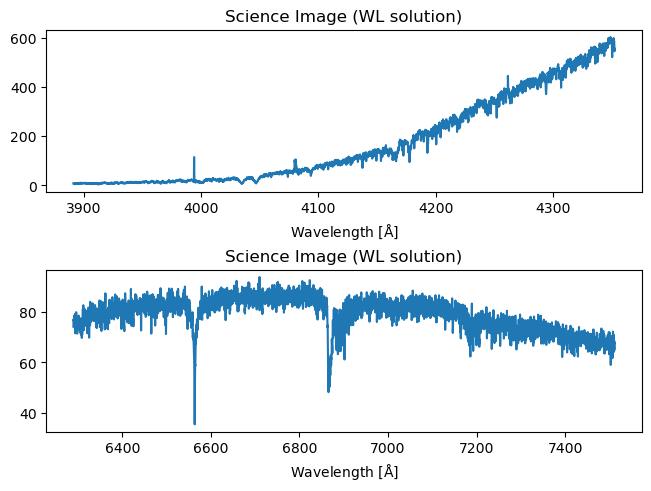

In [71]:
fig, [ax1, ax2] = plt.subplots(2, 1, layout='constrained')
ax1.plot(m1_model(xvals[~badmom_m1]), m1_spec)
ax2.plot(m5_model(xvals[~badmom_m5]), m5_spec)

[ax.set_xlabel(r"Wavelength [$\rm{\AA}$]") for ax in [ax1, ax2]]
[ax.set_title("Science Image (WL solution)") for ax in [ax1, ax2]]

## Toss out M1 images

(6500.0, 6650.0)

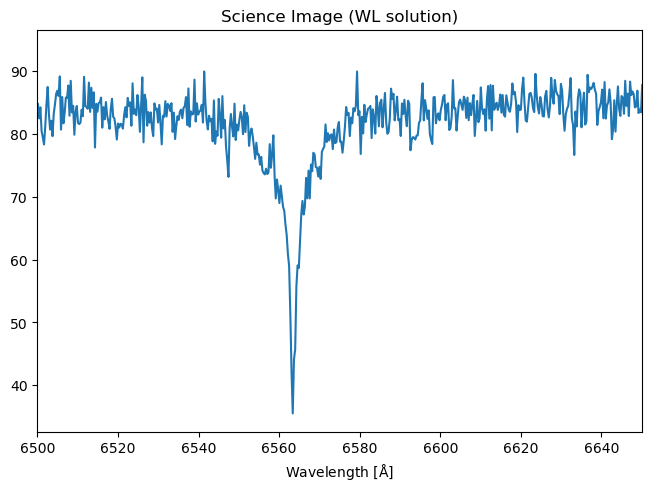

In [72]:
fig, ax = plt.subplots(1, 1, layout='constrained')
ax.plot(m5_model(xvals[~badmom_m5]), m5_spec)
ax.set_xlabel(r"Wavelength [$\rm{\AA}$]")
ax.set_title("Science Image (WL solution)")
ax.set_xlim(6500, 6650)

In [73]:
m5_spec = np.nan_to_num(m5_spec, nan=1, posinf=1, neginf=1)

m5_spec = m5_spec/np.median(m5_spec)
noise_estimate = np.std(m5_spec)


In [95]:

guesses_voigt = [6562.8*u.AA, -1, 8*u.AA, 2*u.AA] # stats

guesses_gauss = [-1, 6562.8*u.AA, 2*u.AA]

In [108]:
wavelengths = m5_model(xvals[~badmom_m5]) * u.AA

selection = (wavelengths > 6545 * u.AA) & (wavelengths < 6590 * u.AA)
absorption_model_guess = Gaussian1D(*guesses_gauss) + Linear1D(intercept=1, slope=0) 

fitter = fitting.SLSQPLSQFitter()
fitted_gaussian = fitter(absorption_model_guess, wavelengths[selection], m5_spec[selection],
                         weights=noise_estimate)
fitted_gaussian

fin = Voigt1D(*guesses_voigt) + Linear1D(intercept=1, slope=0) + Lorentz1D(amplitude=-3, x_0=6562.8*u.AA, fwhm=2*u.AA)
fitted_voigt = fitter(fin, wavelengths[selection], m5_spec[selection],
                         weights=noise_estimate)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.002383540163339291
            Iterations: 15
            Function evaluations: 98
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.000983192835874329
            Iterations: 31
            Function evaluations: 318
            Gradient evaluations: 31


(6500.0, 6650.0)

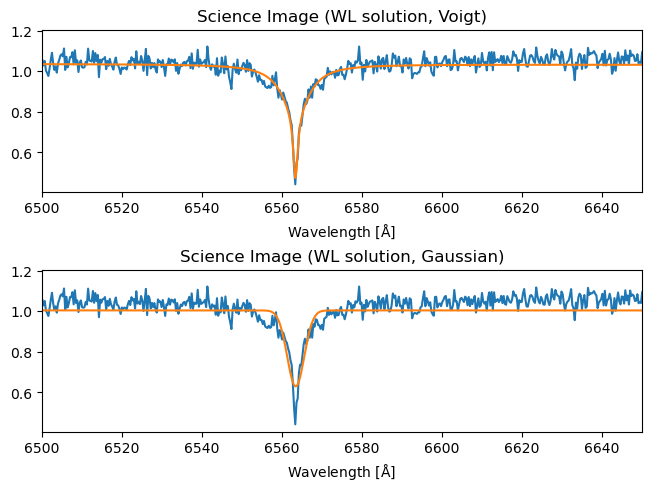

In [109]:
fig, [ax1, ax2] = plt.subplots(2, 1, layout='constrained')
ax1.plot(m5_model(xvals[~badmom_m5]), m5_spec)
ax1.plot(wavelengths, fitted_voigt(wavelengths))
ax1.set_xlabel(r"Wavelength [$\rm{\AA}$]")
ax1.set_title("Science Image (WL solution, Voigt)")
ax1.set_xlim(6500, 6650)

ax2.plot(m5_model(xvals[~badmom_m5]), m5_spec)
ax2.plot(wavelengths, fitted_gaussian(wavelengths))
ax2.set_xlabel(r"Wavelength [$\rm{\AA}$]")
ax2.set_title("Science Image (WL solution, Gaussian)")
ax2.set_xlim(6500, 6650)


In [144]:
absorption  = fitted_voigt[0] + fitted_voigt[2]
continuum = fitted_voigt[1]

(6500.0, 6650.0)

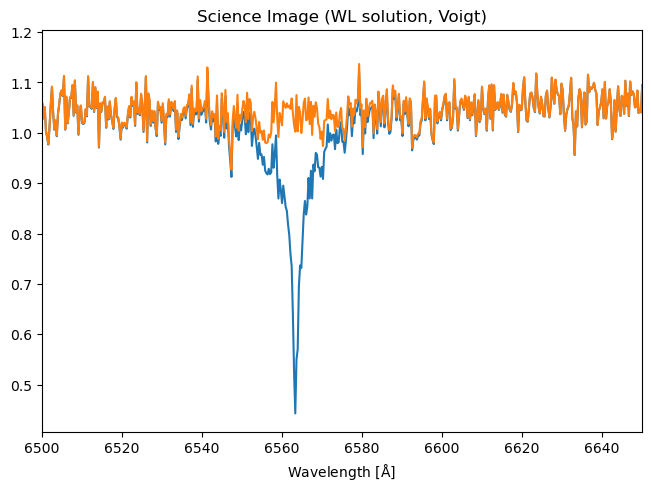

In [147]:
fig, ax1 = plt.subplots(1, 1, layout='constrained')
ax1.plot(m5_model(xvals[~badmom_m5]), m5_spec)
ax1.plot(wavelengths, m5_spec-absorption(wavelengths))
ax1.set_xlabel(r"Wavelength [$\rm{\AA}$]")
ax1.set_title("Science Image (WL solution, Voigt)")
ax1.set_xlim(6500, 6650)

In [150]:
EQW = (
    -absorption(wavelengths[selection]).sum() / continuum.intercept * u.AA
)
EQW

<Quantity 9.34721757 Angstrom>

In [ ]:
fig, ax = plt.subplots(1, 1, layout='constrained')
ax.plot(m5_model(xvals[~badmom_m5]), m5_spec)
ax.plot(wavelengths,m5_spec-absorption_fit(wavelengths.value))
ax.set_xlabel(r"Wavelength [$\rm{\AA}$]")
ax.set_title("Science Image (WL solution)")
ax.set_xlim(6500, 6650)